#  MIDS W207 

## Authors: Neha Kumar, Suhas Gupta
## Submission Date: 04/06/2019 

# Problem Description

We are given a set of training data from Kaggle (https://www.kaggle.com/c/sf-crime/leaderboard) and a set of test data. Given the features in the test data, we need to classify the type of crime. The fields in the dataset are summarized below. Primarily, our dataset is comprised of location and temporal data (where and when was the crime created). Note that there are some datasets that cannot be used for training the model, as they are not accessible to the test model (such as the Descript and Resolution parameters), though we can definitely look to these fields in our error analysis.

Additionally, we plan on using feature engineering to extract useful parameters from the termporal and location data, further detailed below. This, in conjunction with using classification-based models, will aid us in producing a model with the smallest log-loss score (the evaluation criteria for this Kaggle competition)

## Competition data set details from Kaggle

### Data fields
- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

The variables we can use to generate the model will need to be in both the train and test dataset. This gives us:
- Dates
- DayOfWeek
- PdDistrict
- Address
- X
- Y

In [1]:
# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# SK-learn libraries for learning and preprocessing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectFromModel

# Libraries for imbalanced classes
import imblearn 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# Set the figure size for seaborn plots
sns.set(rc={'figure.figsize':(15,15)})

# Import system utilities
import sys as sys

We selected the SF Crime competition

https://www.kaggle.com/c/sf-crime/data

## Data Import and EDA

In [2]:
# Define a data pre processing class

class import_EDA:
    '''
        Parameters: 
        Methods: 
          
    '''
    def __init__(self,trainCSV='./train.csv',testCSV='./test.csv'):
        """Create a new instance of the data import and EDA class object
        Parameters:
            trainCSV: CSV file containing training data 
            testCSV: CSV file containing test data used by Kaggle for model evaluation
            
        """
        self._trainCSV = trainCSV
        self._testCSV = testCSV
        self._train = pd.DataFrame()
        self._test = pd.DataFrame()

    def importToPandas(self):
        '''Import the CSV files and return pandas data frames'''
        self._train=pd.read_csv(self._trainCSV)
        self._test=pd.read_csv(self._testCSV)
        return self._train,self._test
    
    def displayDataFrame(self,dataFrame,rows=5):
        #dataFrame.style.format()
        display(dataFrame[:rows])
        
    def featureDiff(self,train,test):
        diff = set(train.columns) - set(test.columns)
        return diff
    
    def plotDFDistribution(self,dataFrame,categoryName):
        plt.figure(figsize=(15,15))
        g = sns.countplot(data = dataFrame, x = categoryName,orient='h',)
        plt.ylabel("Total Count")
        plot_obj = plt.xticks(rotation=90)
        return plot_obj
    
    def plotDistGrid(self,dataFrame,plot_list,rows,cols):
        counter = 0
        fig, axs = plt.subplots(ncols=cols,nrows=rows,figsize=(25,25))
        if len(plot_list)<rows*cols: # if the plot list is odd then duplicate the last plot and then delete
            new_plot_list = plot_list.copy()
            new_plot_list.append(plot_list[-1])
        else:
            new_plot_list = plot_list
        for row in range(0,rows):
            for col in range(0,cols):
                sns.countplot(data = dataFrame, x = new_plot_list[counter],orient='h',ax=axs[row,col])
                axs[row,col].tick_params(axis='x', rotation=90)
                counter+=1
        if len(plot_list)<rows*cols:
            fig.delaxes(ax = axs[rows-1,cols-1])
            axs[rows-1,cols-2]
        return fig,axs
    
    def plotColdist(self,dataFrame,colName):  
        '''Plot colName data grouped by day of the week and hour of the day'''
        fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False, sharey=False, figsize = (15, 15))
        plt.subplots_adjust(top = 1.1)
        
        all_categories = dataFrame[colName].value_counts().index.tolist()
        for category in range(len(all_categories)):
            my_cat = all_categories[category]
            df = dataFrame.loc[dataFrame[colName] == my_cat,:]
            df = df.groupby(['Hour','DayOfWeek']).count()['X']
            df = df.reset_index(level='Hour').reset_index(level = 'DayOfWeek')
            df = df.pivot(index='Hour', columns='DayOfWeek', values='X').reset_index()

            ax = plt.subplot(8, 5, category + 1)  
            hour = df['Hour'].values 
            days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
            colors = ['red','orange','yellow','green','blue','purple','pink']

            for i in range(len(days)):
                if days[i] in df.columns:
                    ax.plot(hour,df[days[i]].values, colors[i])
            ax.set_title(my_cat)
            
        return ax

    def describeData(self,dataFrame):
        # Find if there are any NA values in the data frame columns 
        if(dataFrame.isnull().values.any()):
            null_values_bool = 0
        else:
            null_values_bool = 1
        row_count = len(dataFrame)
        dataTypes = dataFrame.dtypes
        return null_values_bool,row_count,dataTypes
   
    def splitDate(self,train,test):
        '''This method will import new data frames if not passed from function call
           and split the date column in year, month, hour, minutes'''
        
        # Get years
        train['Year'] = (pd.to_numeric(train['Dates'].str.split('-').str[0])).astype('int16')
        test['Year'] = (pd.to_numeric(test['Dates'].str.split('-').str[0])).astype('int16')
        
        # Get months
        train['Month'] = (pd.to_numeric(train['Dates'].str.split('-').str[1])).astype('int8')
        test['Month'] = (pd.to_numeric(test['Dates'].str.split('-').str[1])).astype('int8')
       
        # Get day
        train['DayOfMonth'] = pd.to_numeric(train['Dates'].str.split(' ').str[0].str.split('-').str[2]).astype('int8')
        test['DayOfMonth'] = pd.to_numeric(test['Dates'].str.split(' ').str[0].str.split('-').str[2]).astype('int8')
       
        # Get hour of the day
        train['Hour'] = (pd.to_datetime(train['Dates'],infer_datetime_format=True).dt.hour).astype('float64')
        test['Hour'] = (pd.to_datetime(test['Dates'],infer_datetime_format=True).dt.hour).astype('float64')
        
        # Get minutes of the hour
        train['Minutes'] = pd.to_numeric(train['Dates'].str.split(' ').str[1].str.split(':').str[1]).astype('int8')
        test['Minutes'] = pd.to_numeric(test['Dates'].str.split(' ').str[1].str.split(':').str[1]).astype('int8')
        
        return train, test
    
    def generateZipCodes(self,dataFrame,zip_list):
        # Building a KNN Model with n_neighbors = 1 on the lat/long coordinates
        zip_features = zip_list[['longitude','latitude']]
        zip_features.columns = ['X', 'Y']
        zip_data = zip_features.values
        zip_labels = zip_list['zip_code'].values
        zip_prediction_set = dataFrame[['X','Y']].values

        knn_zip = KNeighborsClassifier(n_neighbors = 1)
        predictions = knn_zip.fit(zip_data, zip_labels).predict(zip_prediction_set)

        # Add the generated zip codes to the data frame
        dataFrame['Zipcode'] = predictions
        return dataFrame
    
    def addUSHolidays(self,dataFrame):
        '''Check for US holidays based on the Dates and add a boolean feature indicating a holiday or not'''
        # Checking for US Holidays
        # Load in holidays dataframe (source: https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020)
        holidays = pd.read_csv('./usholidays.csv')

        # Make is_holiday flag
        dates_train = (dataFrame['Dates'].str.split(' ').str[0])
        dataFrame['is_holiday'] = dates_train.isin(holidays.Date).astype('int8')
        proportion_holidays = dataFrame['is_holiday'].sum() / dataFrame.shape[0]

        return dataFrame


In [3]:
# Create importData_EDA object
dataImport = import_EDA()
train,test = dataImport.importToPandas()
sample_submission = pd.read_csv('sampleSubmission.csv')

In [4]:
# Check if the training of test sets have any NULL values
null_train,count_train,dTypes_train= dataImport.describeData(train)
null_test,count_test,dTypes_test = dataImport.describeData(test)

print("Number of rows in training dataset:{fm}".format(fm=count_train))
print("Number of rows in test dataset:{fm}".format(fm=count_test))

if(null_train==0):
    print("NULL values found in the training dataset")
else:
    print("No NULL values in the training dataset") 

if(null_test==0):
     print("NULL values found in the test dataset") 
else:
    print("No NULL values in the test dataset")
    
print("\n------------- Data Types[Training Data]-----------------\n")
print(dTypes_train)

print("\n------------- Data Types[Test Data]-----------------\n")
print(dTypes_test)

Number of rows in training dataset:878049
Number of rows in test dataset:884262
No NULL values in the training dataset
No NULL values in the test dataset

------------- Data Types[Training Data]-----------------

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

------------- Data Types[Test Data]-----------------

Id              int64
Dates          object
DayOfWeek      object
PdDistrict     object
Address        object
X             float64
Y             float64
dtype: object


- The output above shows that there are no missing values in the Kaggle datasets for both training and test data. Thus we do not need to account for missing values in our EDA and model development.

- We can also see from above, that all the variables except geographical coordinates (X,Y) are categorical. Thus we will need to perform feature encoding to enable the use of sklearn's modeling and prediction algorithms.

In [5]:
## Lets look at the first samples in the data sets

print("------------------------------------------- Top 5 rows in training dataset ------------------------------------------")
print("---------------------------------------------------------------------------------------------------------------------")
dataImport.displayDataFrame(train,5)

print("\n--------------------------------------------- Top 5 rows in test dataset --------------------------------------------")
print("---------------------------------------------------------------------------------------------------------------------\n")

dataImport.displayDataFrame(test,5)

print("\n-------------------------Features in training dataset not present in test dataset-------------------------\n")
diffFeatures = dataImport.featureDiff(train,test)
print(diffFeatures)

------------------------------------------- Top 5 rows in training dataset ------------------------------------------
---------------------------------------------------------------------------------------------------------------------


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541



--------------------------------------------- Top 5 rows in test dataset --------------------------------------------
---------------------------------------------------------------------------------------------------------------------



,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412



-------------------------Features in training dataset not present in test dataset-------------------------

{'Descript', 'Resolution', 'Category'}


#### Let us look at the distribution of outcome variable "Category"

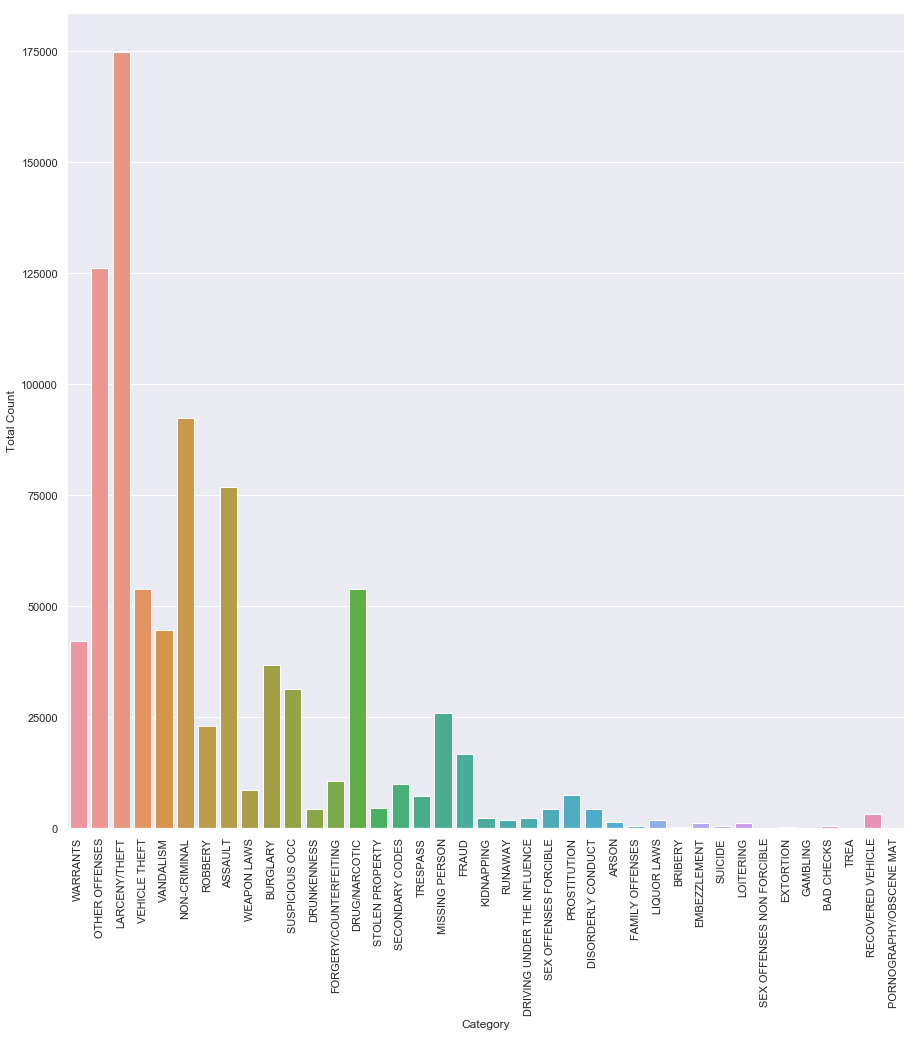

In [6]:
# Plot the distribution of the crime categories from the training data set
tmp = dataImport.plotDFDistribution(train,'Category')

The above plot shows the frequency distribution of the outcome variable **Category**. We can see that we have a heavy imbalance in the class counts. The most frequent crime cateogry is **LARCENY/THEFT** followed by **OTHER OFFSENSES** and **NON-CRIMINAL**. We will need to account for the heavy imbalance in our classes while choosing the appropriate training classifier model for our problem. A baseline model could just be one that predicts every outcome as LARCENY/THEFT.

In [7]:
# Create another instance of train,test data set for feature engineering
dataImport_v2 = import_EDA()
train_v2,test_v2= dataImport_v2.importToPandas()

# Split the date category to years,hours,months
train_v2,test_v2 = dataImport_v2.splitDate(train_v2,test_v2)

As a first step to our feature engineering, we extract the elements of the date to make them more usable. Here, we extract the year, the month, the day of the month, hour, and minutes. The goal of this step is to see if there is any periodic behavior with these components of time. For example, crime rates can overall be stable year after year, but fluctuate sesonally or on an hourly basis throughout the day. These fluctuations will be captured if we extract the date parts from the timestamp rather than using the full timestamp given in the original dataset

In [8]:
print('\nTraining data set after date split\n')
dataImport.displayDataFrame(train_v2,5)
      
print('\nTest data set after test split')
dataImport.displayDataFrame(test_v2,5)


Training data set after date split



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30



Test data set after test split


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45


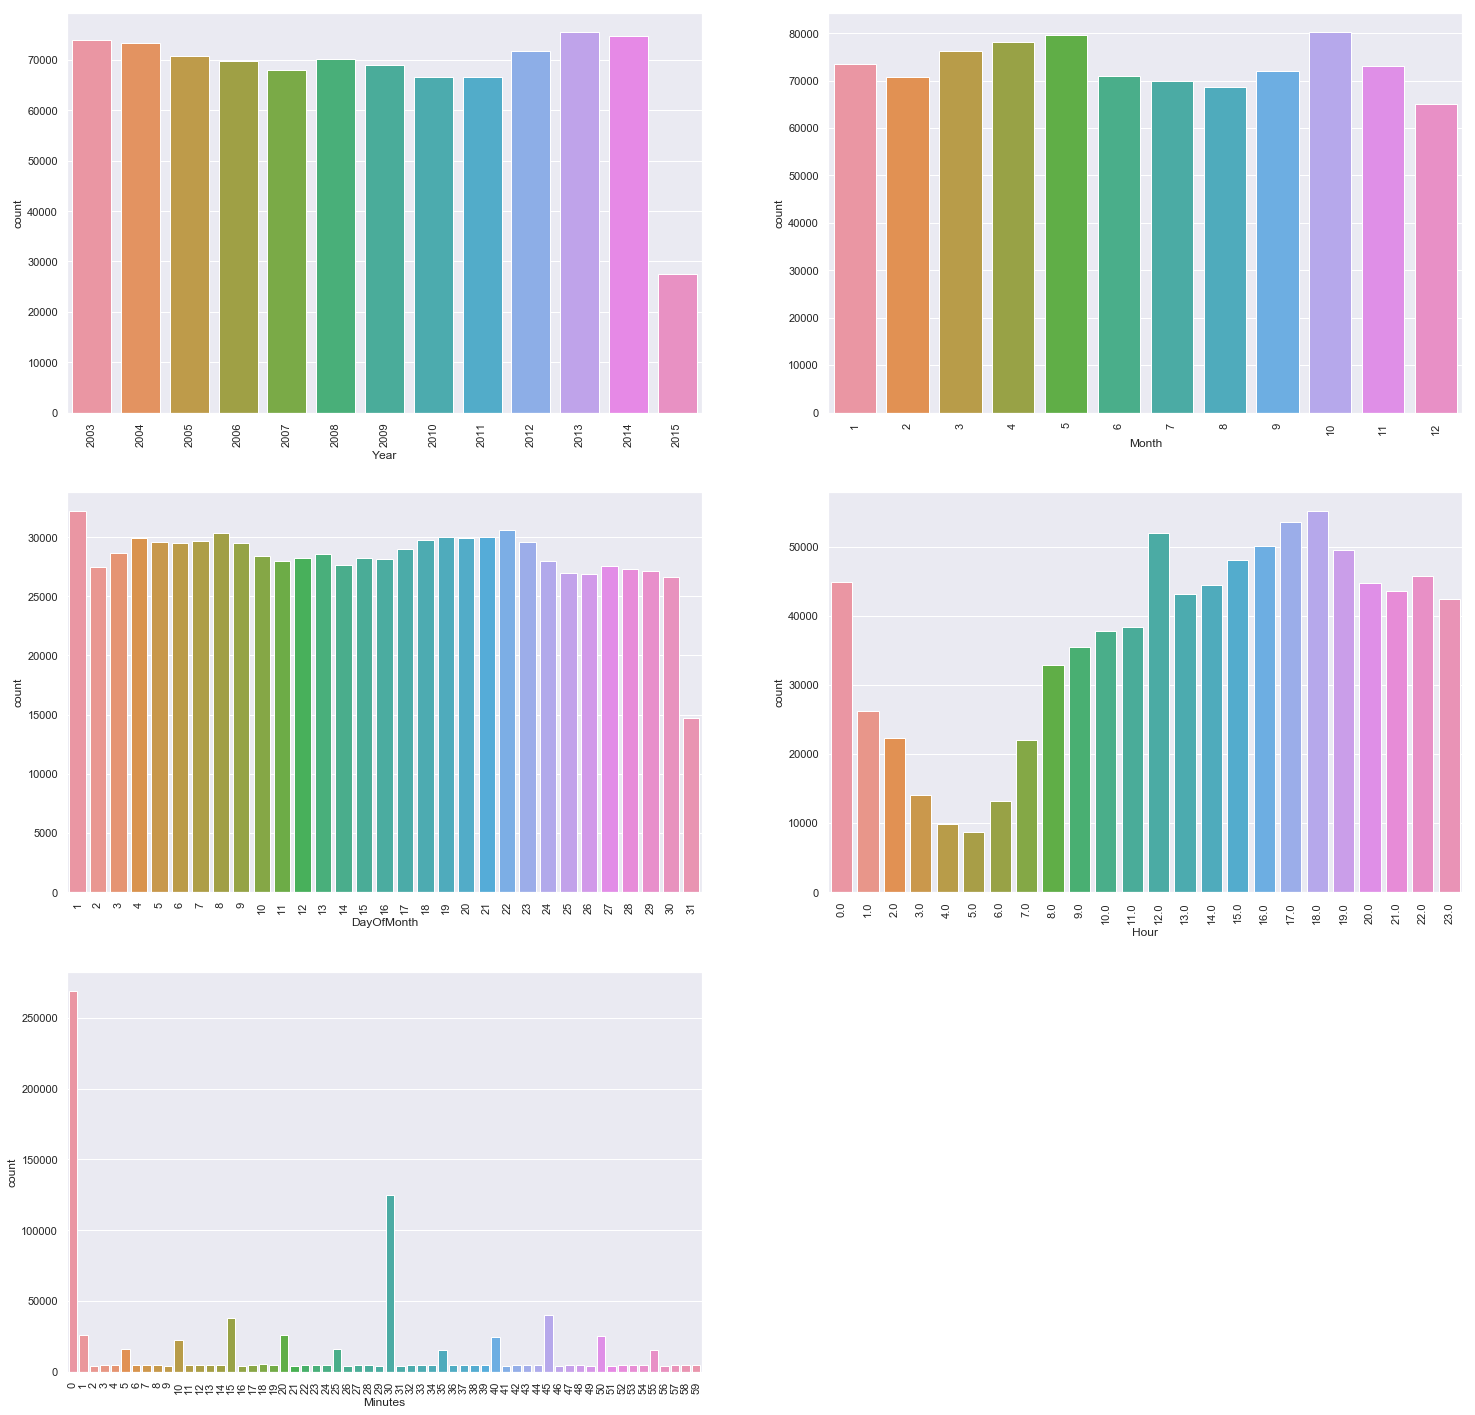

In [9]:
plot_list = ['Year','Month','DayOfMonth','Hour','Minutes']
fig,axs= dataImport_v2.plotDistGrid(train_v2,plot_list,3,2)

- All the years appear to be evenly distributed in the data set, i.e. there is no distinction boundary apparent in the crime categories from just the year data.
- Month:
- Day:
- Hour:

### Adding zip codes to the feature set

We wanted to add zipCode information as a way to group together locations that are close together. As the neighborhoods of SF are quite different from one another, we felt this would be a useful feature for our analysis

To get the Zip Codes, we first tried to use geopy's reverse geocode mapping to get the full address (With the zipcode) from the lat/long coordinates. However, we were hitting into a "too many requests" error. Best practices recommend we make 1 request per second. As our training dataset has about 800k records, running this API will take close to 10 days. 

As a result, we pivoted to another strategy. Using the information here https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude, we got a CSV with all of the lat/long coordinates cooresponding to each zip code. We then used k nearest neighbors with this CSV as the training dataset (with KNN = 1) to find the zip code whose lat/long coordinate is closest to the crime locatiom.

As a caveat, this assumes that zip codes are circular regions (when in reality they are irregularly shaped). However, this approximation runs much faster than using an API, so we will use this way of determining zip codes.

       zip_code   latitude   longitude
39798     94101  37.784827 -122.727802
39799     94102  37.779278 -122.416582
39800     94103  37.775678 -122.412131
39801     94104  37.790728 -122.401732
39802     94105  37.789595 -122.395631


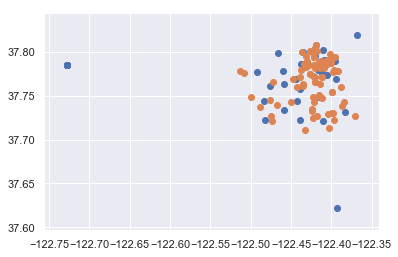

In [10]:
# Source of data https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude
zips = pd.read_csv('zip_codes_states.csv')
sf_zips = zips[zips['city'] == 'San Francisco'][['zip_code','latitude','longitude']]

# Plotting the SF Zip code midpoints with some crime locations to ensure that the data pulled in via CSV makes ense
print(sf_zips[:5])
plt.scatter(sf_zips['longitude'],sf_zips['latitude'])
demo = train[:100]
plt.scatter(demo['X'],demo['Y'])

From the above, we see that the zip code center points (in blue) are in line with the first 100 features from our training dataset (green). This was a gut check to ensure that our zip code data that we imported in makes sense. Now we use KNN to generate the zip codes for our feature set

In [11]:
train_v2 = dataImport_v2.generateZipCodes(train_v2,sf_zips)
test_v2 = dataImport_v2.generateZipCodes(test_v2,sf_zips)

In [12]:
print('\nTraining data set after zipcode addition\n')
dataImport_v2.displayDataFrame(train_v2,5)
      
print('\nTest data set after zipcode addition')
dataImport_v2.displayDataFrame(test_v2,5)


Training data set after zipcode addition



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117



Test data set after zipcode addition


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59,94124
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51,94124
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50,94109
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112


Let's look at the distribution of the generated zip codes in the training and test data sets

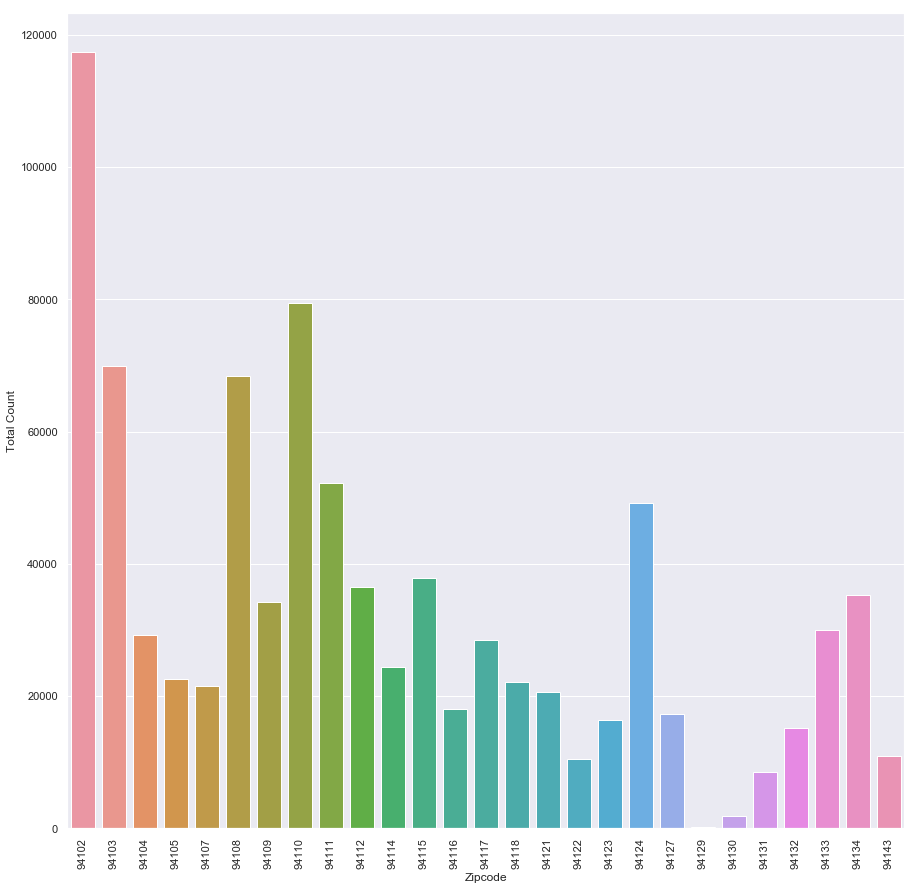

In [13]:
g = dataImport_v2.plotDFDistribution(train_v2,'Zipcode')

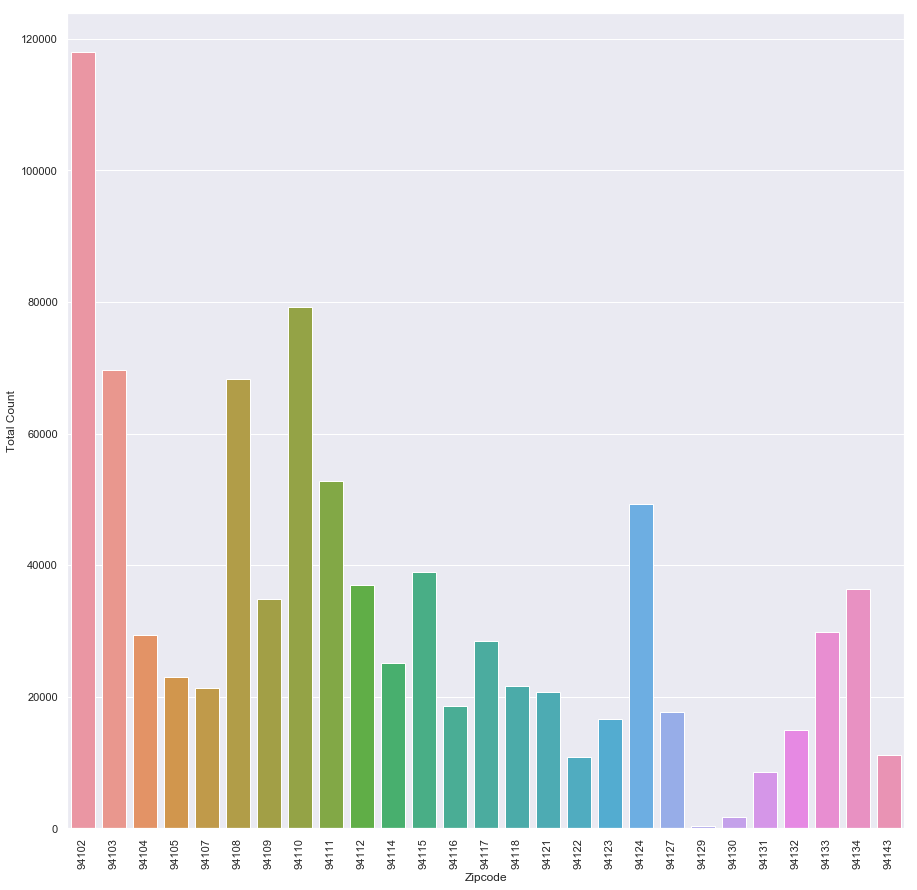

In [14]:
g = dataImport_v2.plotDFDistribution(test_v2,'Zipcode')

The zipcode distribution looks similar between training and test datasets

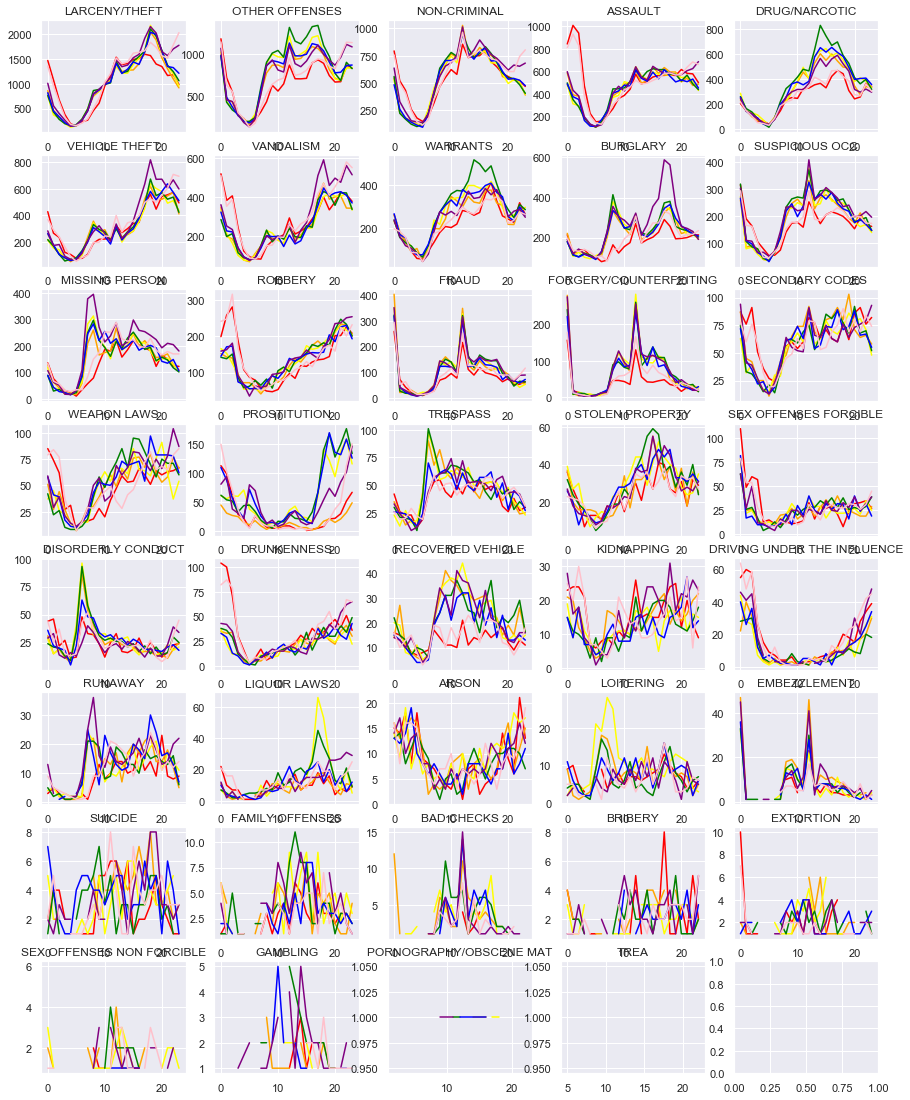

In [15]:
ax = dataImport_v2.plotColdist(train_v2,'Category')

Next, we want to add a marker on whether or not a day is a national holiday. We suspect this is a useful feature as more people are out and about / there are more tourists in San Francisco on national holidays. Thus, the crime patterns may differ on these days as opposed to other days. We used a Kaggle dataset of national holidays and compared the dates in the dataset to these holidays, adding a flag when a crime has occurred on a holiday.

In [16]:
train_v2 =  dataImport_v2.addUSHolidays(train_v2)
test_v2 =  dataImport_v2.addUSHolidays(test_v2)

print('\nTraining data set after is_holiday addition\n')
dataImport_v2.displayDataFrame(train_v2,5)
      
print('\nTest data set after is_holiday addition')
dataImport_v2.displayDataFrame(test_v2,5)


Training data set after is_holiday addition



,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117,0



Test data set after is_holiday addition


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5,10,23.0,59,94124,0
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5,10,23.0,51,94124,0
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5,10,23.0,50,94109,0
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112,0
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5,10,23.0,45,94112,0


In [17]:
## Calculate fraction of crimes committed on holidays
proportion_holidays = train_v2['is_holiday'].sum() / train_v2.shape[0]
print('The proportion of crime records on US recognized holidays is {fm}%'.format(fm=100*round(proportion_holidays,5)))
print('The proportion of crime records NOT on US recognized holidays is {fm}%'.format(fm=100*round(1 - proportion_holidays,5)))


The proportion of crime records on US recognized holidays is 2.866%
The proportion of crime records NOT on US recognized holidays is 97.134%


In [18]:
## Deal with geo-coordinates
# Remove latitude of 90 degress (this indicates north pole which points to incorrect data collection or recording)
train_v2 = train_v2[train_v2.Y < 90]

In [19]:
dataImport_v2.displayDataFrame(train_v2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,DayOfMonth,Hour,Minutes,Zipcode,is_holiday
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23.0,53,94102,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23.0,33,94109,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23.0,30,94109,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23.0,30,94117,0


## Feature Engineering

In [20]:
class createTestTrainData:
    '''
        Parameters: 
            trainDataFrame: Pandas DF containing training data
            testDataFrame: Pandas DF containing test data
            outcome : [String] Predicted variable name in the data frame
            removeCategories: [List] Categories to be removed from the training data frame to match test data shape
            trainDataEncoded: Numpy data array containing encoded feature set for training data
            trainlabelsEncoded: Numpy data array containing encoded dataset for training labels
            mini_size: Size of the mini training data and label set to create
            r_seed: Random seed for test train split 
            t_size: Size of dev dataset
            shuffle: Boolean indicating shuffling of data for test train split
            
        Methods: 
            getDataSets(): Converts the pandas data frames for test and training data to numpy arrays for modeling
            testTrainSplit(): Splits dataset into training and development data sets         

    '''
    def __init__(self,trainDataFrame=pd.DataFrame(),testDataFrame=pd.DataFrame(),outcome='Category',
                 removeCategoriesTrain=['Category','Descript','Resolution'],
                 removeCategoriesTest= ['Category','Descript','Resolution'],
                 trainDataEncoded=[],trainlabelsEncoded=[], 
                 mini_size = 1000, r_seed = 1, t_size = 0.20, shuffle=True):
        
        # Parameters for data set creation
        self._trainDataFrame = trainDataFrame
        self._testDataFrame = testDataFrame
        self._remCatsTrain = removeCategoriesTrain  # categories to remove from the training dataset
        self._remCatsTest = removeCategoriesTest  # categories to remove from the test dataset

        self._labelCat = outcome # define the outcome category
        
        # Parameters for test train data split
        self._r_seed = r_seed
        self._shuffle = shuffle
        self._t_size = t_size
        self._mini_size = mini_size
        self._encodedData = trainDataEncoded
        self._encodedLabels = trainlabelsEncoded
 
    def getDataSets(self):
        """ Process pandas dataframe and return numpy arrays """
        
        data_train_df = self._trainDataFrame.drop(self._remCatsTrain,axis=1)
        labels_train_df = pd.DataFrame(self._trainDataFrame, columns = [self._labelCat])

        ## Convert data frame to numpy arrays
        data_train = data_train_df.values
        labels_train = labels_train_df.values
        ## Store the feature names in a list
        train_features_names = list(data_train_df.keys())
        ## Remove ID column from test data
        self._testDataFrame = self._testDataFrame.drop(self._remCatsTest,axis=1)
        test_data = self._testDataFrame.values
        test_feature_names = list(self._testDataFrame.keys())
        
        return data_train,labels_train,test_data,train_features_names,test_feature_names
    
    def testTrainSplit(self):
        """ Split into training, dev and mini training data sets """
        train_data, dev_data, train_labels, dev_labels = train_test_split(self._encodedData, self._encodedLabels,test_size = self._t_size, random_state = self._r_seed,shuffle=self._shuffle)
        mini_train_data, mini_train_labels = train_data[:self._mini_size], train_labels[:self._mini_size]
        return train_data, dev_data, mini_train_data, train_labels, dev_labels, mini_train_labels
    
    def testTrainSplitBatches(self,num_batches,mini_size=100000):
        """ Split into smaller random splits for ensemble model training 
            This method only return mini training data set and labels, dev data set and labels"""
        mini_train_data = []
        mini_train_labels= []
        dev_data = []
        dev_labels = []

        for i in range(0,num_batches):
        #     # Change the random seed to create random subsets
            splitData = createTestTrainData(trainDataEncoded = data_train_encoded_v2,trainlabelsEncoded=labels_train_encoded_v2, 
                                                   mini_size = mini_size, r_seed=i*2, t_size = dev_size, shuffle=shuffle)
            train_data, dev_data_tmp, mini_train_data_tmp, train_labels, dev_labels_tmp, mini_train_labels_tmp = splitData.testTrainSplit()
            dev_data.append(dev_data_tmp)
            dev_labels.append(dev_labels_tmp)
            mini_train_data.append(mini_train_data_tmp)
            mini_train_labels.append(mini_train_labels_tmp)

        return mini_train_data,mini_train_labels,dev_data,dev_labels
    

In [21]:
# Define a data pre processing class

class featureProcessor:
    '''
        Parameters: 
            dataset: Numpy array containing data with features and samples 
            encode: Boolean indicating encoding of data
            encodeScheme: String value indicating scheme to use for encoding 
 
        Methods: 
            encodeTrainData(): Encodes the data using encodeScheme and returns transformed datasets
            encodeLabels(): Encodes the labels using encodeScheme and returns transformed label sets and class names

    '''
    
    def __init__(self,encode=0,numericencodeScheme='MinMax',catencodeScheme='oneHot',labelEncodeScheme='label'):
        """Create a new instance of the preprocessing object
        Parameters: 
            encode : Binary [1: encode based on encodeScheme ; 0 : no encoding]
            dataencodeScheme: Scheme for encoding data set
            labelEncodeScheme: Scheme for encoding label data
        """
        self._encode = encode
        self._numEncodeScheme = numericencodeScheme
        self._catEncodeScheme = catEncodeScheme
        self._labelEncodeScheme = labelEncodeScheme
        self._numencoders ={'MinMax': preprocessing.MinMaxScaler(copy=True,feature_range=(0,1))}
        self._catencoders = {'oneHot': preprocessing.OneHotEncoder(handle_unknown="ignore")}
        self._labelencoders = {'label': preprocessing.LabelEncoder()}
        
        ## Test for argument fidelity
        if (self._encode and (self._catEncodeScheme=="NULL" or self._labelEncodeScheme=="NULL") or self._numEncodeScheme=="NULL"):
            raise ValueError("encode schemes for data or labels can't be NULL when encode !=0")     
        if (self._numEncodeScheme not in self._numencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._numEncodeScheme))
        if (self._catEncodeScheme not in self._catencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._catEncodeScheme))
        if (self._labelEncodeScheme not in self._labelencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._labelEncodeScheme))

    def columnTransform(self,num_features,cat_features):
        '''Encode both categorical and numeric data'''
        
        # Numeric encoding setup
        numeric_features = num_features
        numeric_transformer = self._numencoders[self._numEncodeScheme]                                                           
        
        #Categorical encoding setup
        categorical_features = cat_features
        categorical_transformer = self._catencoders[self._catEncodeScheme]
        
        # Create an encoding pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])
    
        return preprocessor
    
    def encodeData(self,trainData,testData,train_feature_names,):
        # Define indeces for categorical and numerical features
        num_features=[train_features_names_v2.index('X'),train_features_names_v2.index('Y')]
        cat_features = [i for i,v in enumerate(train_features_names_v2) if i not in num_features]
        if self._encode:
            preprocessor = self.columnTransform(num_features,cat_features)
            preprocessor = preprocessor.fit(trainData)
            transformedDatasetTrain = preprocessor.transform(trainData)
            transformedDatasetTest = preprocessor.transform(testData)
        else:
            transformedDatasetTrain = trainData
            transformedDatasetTest = testData
        
        return transformedDatasetTrain,transformedDatasetTest
    
    def encodeLabels(self,labelset):        
        # Encode label data
        enc = self._labelencoders[self._labelEncodeScheme]
        if self._encode:
            transformedLabelset = enc.fit_transform(np.ravel(labelset.reshape(-1,1)))
            data_classes = enc.classes_
        else:
            transformedLabelset = labelset
            data_classes = np.unique(transformedLabelset)
        return transformedLabelset,data_classes

In [22]:
''' FOR v2 DATA: Import the data frames into numpy arrays and remove extraneous categories 
    Outcome Variable: Category [This is what we will predict and it forms a separate array]
'''
removeCatsTrain_v2 = ['Category','Descript','Resolution', 'Dates']
removeCatsTest_v2 = ['Id', 'Dates']

outcomeLabel = 'Category' 
importdata_v2 = createTestTrainData(trainDataFrame=train_v2,testDataFrame=test_v2,outcome=outcomeLabel,
                                    removeCategoriesTrain=removeCatsTrain_v2,removeCategoriesTest=removeCatsTest_v2)
data_train_v2,labels_train_v2,test_data_v2,train_features_names_v2,test_feature_names_v2 = importdata_v2.getDataSets()

# Check shape of all arrays
print('Shape of training data: {train_shp1}'.format(train_shp1=data_train_v2.shape))
print('Shape of training labels: {train_shp2}'.format(train_shp2=labels_train_v2.shape))
print('List of training features:', train_features_names_v2)
print('Shape of test data:', test_data_v2.shape)
print('List of test features:', test_feature_names_v2)

# Confirm that training and test data have same features at this stage
assert train_features_names_v2==test_feature_names_v2, "Training and Test features are not same!!"


Shape of training data: (877982, 12)
Shape of training labels: (877982, 1)
List of training features: ['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']
Shape of test data: (884262, 12)
List of test features: ['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Year', 'Month', 'DayOfMonth', 'Hour', 'Minutes', 'Zipcode', 'is_holiday']


In [23]:
''' FOR V2 DATA: Encoded data using one Hot Encoding'''
numEncodeScheme = 'MinMax' # use Min Max scaling for X & Y 
catEncodeScheme = 'oneHot' # use one Hot scheme
labelEncodeScheme  = 'label' # use label encoder (category to ordered numeric)
encode = 1  # to encode or not to encode
fp_v2 = featureProcessor(encode,numEncodeScheme,catEncodeScheme,labelEncodeScheme)   

data_train_encoded_v2,test_data_encoded_v2= fp_v2.encodeData(data_train_v2,test_data_v2,train_features_names_v2)
labels_train_encoded_v2, data_classes_v2 = fp_v2.encodeLabels(labels_train_v2)

'''Split data in train, dev and mini_train dataset for training and validating models'''
random_seed = 1
dev_size = 0.20 # Set dev data set size to 20%
shuffle = True # Shuffle the data based on random seed
mini_dataset_size = 1000
splitData_v2 = createTestTrainData(trainDataEncoded = data_train_encoded_v2,trainlabelsEncoded=labels_train_encoded_v2, 
                 mini_size = mini_dataset_size, r_seed=random_seed, t_size = dev_size, shuffle=shuffle)
train_data_v2, dev_data_v2, mini_train_data_v2, train_labels_v2, dev_labels_v2, mini_train_labels_v2 = splitData_v2.testTrainSplit()

# Check shapes of all arrays
print('Shape of encoded training data:',train_data_v2.shape)
print('Shape of encoded test data: ', test_data_encoded_v2.shape) 
print('Shape of encoded labels:', train_labels_v2.shape)
print('Shape of data classes:', data_classes_v2.shape)
print('Shape of dev dataset:',dev_data_v2.shape)
print('Shape of dev label dataset:',dev_labels_v2.shape)
print('Shape of mini training dataset:',mini_train_data_v2.shape)
print('Shape of mini label dataset:',mini_train_labels_v2.shape)

# Confirm that post encoding we have the same features for training and test data
assert train_data_v2.shape[1] == test_data_encoded_v2.shape[1], "Test and Training data have different encoded features!!"

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Shape of encoded training data: (702385, 23379)
Shape of encoded test data:  (884262, 23379)
Shape of encoded labels: (702385,)
Shape of data classes: (39,)
Shape of dev dataset: (175597, 23379)
Shape of dev label dataset: (175597,)
Shape of mini training dataset: (1000, 23379)
Shape of mini label dataset: (1000,)


### Dimensionality Reduction

In [32]:
class modelDev:
    ''' This class defines parameters and methods to assist in classifier training, fitting and dimensionality reduction'''
    
    def __init__(self,train_data,train_labels,dev_data,dev_labels,test_data,reduce=0):
        """Create a new instance of the preprocessing object
        Parameters: 
            reduce : Binary [1: reduce dimensionality based on reduceScheme ; 0 : no dim reduction]
            reduceScheme: Method for dimensionality reduction
        """        
        self._reduce = reduce
        self._train_data = train_data
        self._train_labels = train_labels
        self._dev_data = dev_data
        self._dev_labels = dev_labels
        self._test_data = test_data
        
    def reduceWithL1(self,c_val):
        if self._reduce==1:
            l1 = LogisticRegression(penalty='l1', random_state = random_seed,C = c_val, solver = 'saga', multi_class='auto', tol=.01,n_jobs=-1)
            l1_model = l1.fit(self._train_data, self._train_labels)
            # Get the indices of the non zero features 
            summed_weights = np.sum(l1_model.coef_, axis=0)
            nonzero_index = np.nonzero(summed_weights)[0] 
            n_features = len(nonzero_index)
            all_feature_sets_train = self._train_data[:,nonzero_index]
            all_feature_sets_dev = self._dev_data[:,nonzero_index]
            all_feature_sets_test = self._test_data[:,nonzero_index]
        else:
            nonzero_index = np.arange(0,self._train_data.shape[1])
            all_feature_sets_train = self._train_data[:,nonzero_index]
            all_feature_sets_dev = self._dev_data[:,nonzero_index]
            all_feature_sets_test = self._test_data[:,nonzero_index]
            
        # Check dimensions are ok after reduction
        assert (all_feature_sets_train.shape[0]==self._train_data.shape[0]), "Number of samples post dimensionality reduction are are inconsistent with original train data set" 
        assert (all_feature_sets_dev.shape[0]==self._dev_data.shape[0]), "Number of samples post dimensionality reduction are are inconsistent with original dev data set" 
        assert (all_feature_sets_test.shape[0]==self._test_data.shape[0]), "Number of samples post dimensionality reduction are are inconsistent with original dev data set"     
        return all_feature_sets_train,all_feature_sets_dev,all_feature_sets_test,nonzero_index

    def reduceWithPCA(self,n_comp):
        if self._reduce==1:
            pca = TruncatedSVD(n_components = n_comp)
            pca.fit(self._train_data)
            # Calculate sum of the EVR
            evr = np.concatenate(([0], pca.explained_variance_ratio_))
            sevr = np.cumsum(evr)
            after_transform_features_train = pca.transform(self._train_data)
            after_transform_features_dev = pca.transform(self._dev_data)
            after_transform_features_test = pca.transform(self._test_data)
            # Normalize the values after PCA transform
            after_transform_features_train = (after_transform_features_train - after_transform_features_train.min(axis = 0)) / after_transform_features_train.ptp(axis = 0)
            after_transform_features_dev = (after_transform_features_dev - after_transform_features_dev.min(axis = 0)) / after_transform_features_dev.ptp(axis = 0)
            after_transform_features_test = (after_transform_features_test - after_transform_features_test.min(axis = 0)) / after_transform_features_test.ptp(axis = 0)
            
        else:
            after_transform_features_train = self._train_data
            after_transform_features_dev = self._dev_data
            after_transform_features_dev = self._test_data
            sevr=0
        return after_transform_features_train,after_transform_features_dev,after_transform_features_test,sevr
    
    def gridSearchWithClass(self,train_data,train_labels,param_dict1,clf_name,param2=None):
        if (clf_name is "MNB"):
            clf = MultinomialNB()
        elif (clf is "Logistic"):
            clf = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, solver = 'sag', C = c, max_iter=100, tol = 0.001)
        elif (clf is "DecisionTree"):
            clf = DecisionTreeClassifier(max_depth = md, min_samples_split = param2)
        elif (clf is "RandomForest"):
            clf = RandomForestClassifier()
        clf_optim = GridSearchCV(estimator = clf, param_grid = param_dict1, cv = 3, scoring = 'neg_log_loss', n_jobs=-1,verbose=10)
        clf_optim = clf_optim.fit(train_data, train_labels)
        return clf_optim
    
    def fitClfAndScore(self,train_data,train_labels,param1,dev_data,dev_labels,clf_name,param2=None):
        if (clf_name is "MNB"):
            clf = MultinomialNB(alpha=param1)
        elif (clf is "Logistic"):
            clf = LogisticRegression(penalty='l2',C=param1, multi_class='multinomial',  random_state = 123, solver = 'sag', max_iter=100, tol = 0.001,n_jobs=-1)
        elif (clf is "DecisionTree"):
            clf = DecisionTreeClassifier(max_depth = param1, min_samples_split = param2,n_jobs=-1)
        elif (clf is "RandomForest"):
            clf = RandomForestClassifier(max_depth=param1,n_jobs=-1)
        train_predict = clf.fit(train_data, train_labels).predict_proba(train_data)
        train_score = metrics.log_loss(train_labels, train_predict)
        dev_predict = clf.predict_proba(dev_data)
        dev_score = metrics.log_loss(dev_labels,dev_predict)
        return clf,train_score,dev_score
    

#### 1. PCA

Note: In our earlier submission, we had fewer features in our dataset. Since increasing the number of features (adding the day of month for example), we re-evaluated the need for PCA and saw that the PCA curve more clearly tapers off now with the larger number of features. We will see if this translates to a more robust model. If the model is more robust with PCA, we will keep the PCA features for the rest of our modeling

In [33]:
# Create object of model dev class
modelDev1 = modelDev(train_data_v2,train_labels_v2,dev_data_v2,dev_labels_v2,test_data_encoded_v2,reduce=1)

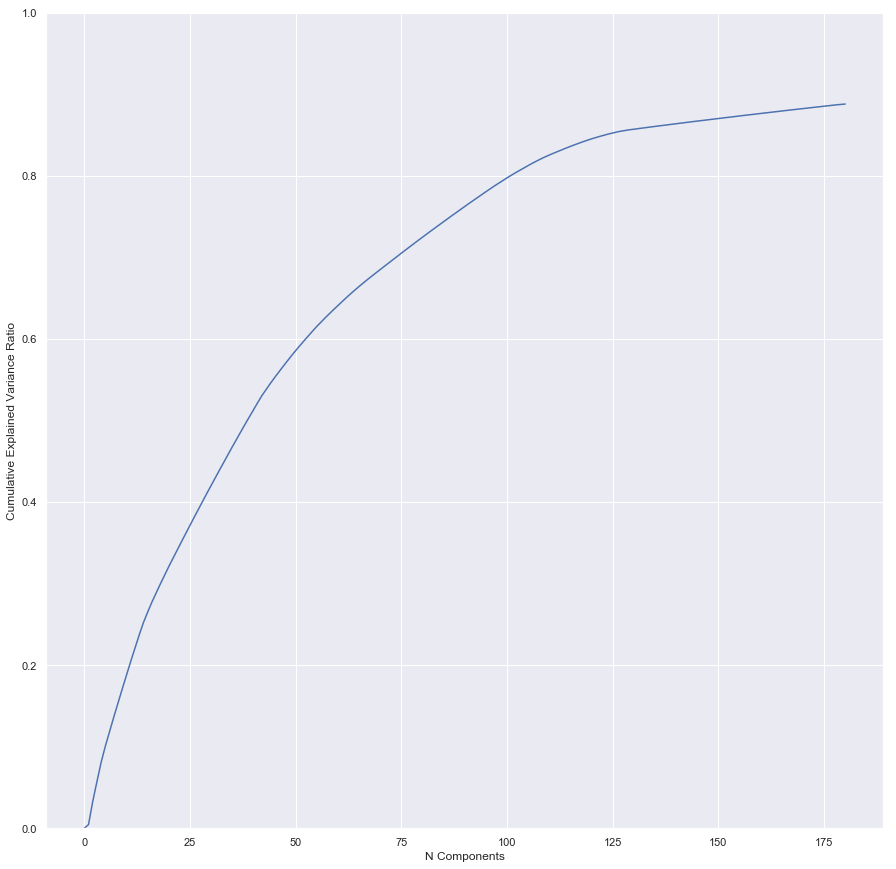

In [26]:
# Number of variables we will use in PCA
n = 180
# Tranform the data sets and visualize the explained variance versus number of components
after_transform_features_train_pca,after_transform_features_dev_pca,after_transform_features_test_pca,sevr_pca = modelDev1.reduceWithPCA(n)
plt.figure(figsize=(15,15))
plt.plot(range(n + 1),sevr_pca)
plt.xlabel('N Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.ylim([0,1])
plt.show()

It looks like the explained variance ratio tapers off at a dimensionality greater than 150. However, there is no clear cut-off point. Let's pivot to L1 to tell us the most key features

#### 2. L1 Regularization with Logistic Regression

In [27]:
# List of c values to fit L1 logistic regression
c_vals = [0.001, 0.005, 0.01, 0.05, 0.1]

# Initialize some data structures
feature_count_v1 = []
nonzero_idx_list_v1 = []
all_feature_sets_train_l1 = []
all_feature_sets_dev_l1 = []
all_feature_sets_test_l1 = []
num_features_list_l1 = []
# Iterate over c_vals to get reduced feature map for the train,dev & test data sets
for idx_c, c in enumerate(c_vals):
    after_transform_features_train_l1,after_transform_features_dev_l1,after_transform_features_test_l1,non_zero_index =modelDev1.reduceWithL1(c) 
    nonzero_idx_list_v1.append(non_zero_index)
    all_feature_sets_train_l1.append(after_transform_features_train_l1)
    all_feature_sets_dev_l1.append(all_feature_sets_dev_l1)
    all_feature_sets_test_l1.append(all_feature_sets_test_l1)
    num_features_list_l1.append(len(non_zero_index))
    print('For a c of', c, 'the number of non zero features is', len(non_zero_index))
    # Break the loop if L1 regularization is no longer removing any features for us (diminishing returns)
    if len(non_zero_index) >= train_data_v2.shape[1] or len(non_zero_index) >= 300:
        break
print("Data set creation with reduced dimensions succeeded!")


For a c of 0.001 the number of non zero features is 54
For a c of 0.005 the number of non zero features is 158
For a c of 0.01 the number of non zero features is 232
For a c of 0.05 the number of non zero features is 1020
Data set creation with reduced dimensions succeeded!


**Comparison of dimensionality reduction methods**

For selecting the appropriate method of dimensionality reduction, we will evalute the performance using a multinomial Naive Bayes classifier: 
 
 1) Grid search Multinomial Naive Bayes(MNB) with full featured training data set to get optimal hyperparameter value
 2) Using the alpha value obtained above, train MNB models on training data sets with PCA and L1 reduced feature sets. Compare the log-loss scores from the two dimensionality reduction methods to select the best method.
 3) Using the reduce feature data sets from above, train all classifiers and meta model for final predictions.


In [28]:
# Define the hyper parameters for GridSearch
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]
params = {'alpha':alphas}

We will use GridSearchCV to find the best parameter value with 3 fold cross validation. GridSearchCV is better than just looping over the parameter values with fitting on training data due to the cross validation methodology. We see below that the best parameter value found by GridSearchCV is close to the optimal value that minimizes overfitting on the development data set. 

In [29]:
# Perform grid search on the full featured training data set
mnb_full_fitted = modelDev1.gridSearchWithClass(train_data_v2,train_labels_v2,params,'MNB')
print('The best value for alpha is (without dimension reduction):', mnb_full_fitted.best_params_['alpha'])
print('Best score from grid search on training data set (without dimension reduction) :{fm}'.format(fm=round(mnb_full_fitted.best_score_,4)))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:   32.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   33.8s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   36.1s finished


The best value for alpha (with feature engineering) is: 0.1
Best score from grid search on training data set (with feature engineering):-2.6153


In [34]:
mnb_full_train_scores = []
mnb_full_dev_scores=[]
for a in alphas:
    print('Running alpha of ',a)
    tmp,train_score,dev_score = modelDev1.fitClfAndScore(train_data_v2,train_labels_v2,a,dev_data_v2,dev_labels_v2,'MNB')
    mnb_full_train_scores.append(train_score)
    mnb_full_dev_scores.append(dev_score)


Running alpha of  1e-07
Running alpha of  1e-06
Running alpha of  1e-05
Running alpha of  0.0001
Running alpha of  0.001
Running alpha of  0.01
Running alpha of  0.1
Running alpha of  0.5
Running alpha of  1.0
Running alpha of  2.0
Running alpha of  10.0
Running alpha of  20
Running alpha of  50
Running alpha of  100
Running alpha of  500
Running alpha of  1000


Lets plot the log loss on a log scale to help in visualizing the underfitting and overfitting regions

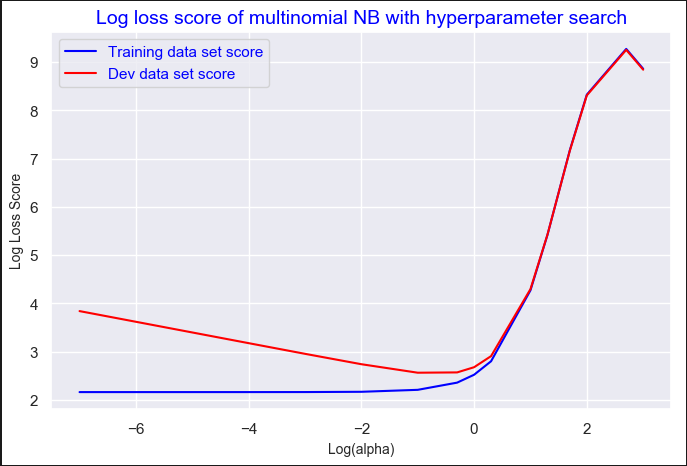

In [40]:
# Plotting log loss scores from above
plt.rcParams['text.color'] = 'blue'
plt.figure(figsize=(8,5),dpi=100, facecolor='w', edgecolor='k',linewidth=1)
plt.plot(np.log10(alphas),mnb_full_train_scores, 'blue',label='Training data set score')
plt.plot(np.log10(alphas),mnb_full_dev_scores, 'red',label='Dev data set score')
plt.xlabel('Log(alpha)',fontsize=10)
plt.ylabel('Log Loss Score',fontsize=10)
plt.title('Log loss score of multinomial NB with hyperparameter search',fontsize=14)
plt.legend()
plt.show()    

The plot above shows that the model is slightly overfitting for the most optimal paramter value of $alpha=0.1$. The parameter value that produces best score on the dev data set is $alpha=1$

In [41]:
# Set the best param value for subsequent models
optim_alpha = 0.1

In [42]:
# Use the PCA reduced feature set to train an MNB classifier and evaluate the log loss performance

mnb_pca,pca_train_score,pca_dev_score = modelDev1.fitClfAndScore(after_transform_features_train_pca,train_labels_v2,optim_alpha,after_transform_features_dev_pca,dev_labels_v2,'MNB')
print("Best training data log loss score with PCA reduced features:",round(pca_train_score,4))
print("Best dev data log loss score with PCA reduced features:",round(pca_dev_score,4))

Best training data log loss score with PCA reduced features: 2.648
Best dev data log loss score with PCA reduced features: 2.6446


In [ ]:
# Use the L1 reduced feature set to train an MNB classifier and evaluate the log loss performance
mnb_l1=[]
mnb_l1_train_scores=[]
mnb_l1_dev_scores=[]
num_features_list_l1 = []

for i in range(len(nonzero_idx_list_v1)):
    tmp,l1_train_score,l1_dev_score = modelDev1.fitClfAndScore(all_feature_sets_train_l1[i],train_labels_v2,optim_alpha,all_feature_sets_dev_l1[i],dev_labels_v2,'MNB')
    mnb_l1_train_scores.append(l1_train_score)
    mnb_l1_dev_scores.append(l1_dev_score)
    num_features_list.append((nonzero_idx_list_v1[i].shape)[0])
    
plt.figure(figsize=(15,15))
plt.xlabel("Number of features in training data set")
plt.ylabel("MNB Log Loss ")
plt.plot(num_features_list, mnb_l1_train_scores)
plt.plot(num_features_list, mnb_l1_dev_scores)


In [ ]:
best_feature_set_idx = np.argmin(mnb_l1_dev_scores)
print('The best feature set has', all_feature_sets_train[best_feature_set_idx].shape[1],'features')
print('The best log loss is', round(mnb_l1_dev_scores[best_feature_set_idx],4))


We see that the best feature set based on negative log loss metric is with 993 non-zero features. The log loss is also lower when running with the reduced feature set when compared to the run with full feature set. Besides, we observe that feature dimension reduction with L1 produces better log loss scores on the dev data set compared to PCA reduced feature dimensions. Thus we will use the training and dev data sets with L1 reduced feature dimensions for all model fitting and cross validation.

In [ ]:
# Display the log loss score comparison for Multinomial Naive Bayes with and without feature reduction
df_table = pd.DataFrame([mnb_full_fitted.best_score_,np.min(mnb_l1_dev_scores[best_feature_set_idx])], columns=['Log Loss Score for MNB'], index=['Without dim reduction', 'With dim reduction'])
dataImport.displayDataFrame(df_table[:])



In [ ]:
train_data_v3 = all_feature_sets_train[best_feature_set_idx]
dev_data_v3 = all_feature_sets_dev[best_feature_set_idx]


## Model fitting and cross validation

### Create random subsets of training data to train models before model aggregation

We will use the reduced feature data set to generate random subsets before training our individual models in the ensemble. These models will then be aggregated using a meta model to make the final prediciton on the test set. 

In [244]:
# num_of_train_batches = 4
# mini_size = 150000
# splitData = createTestTrainData(trainDataEncoded = train_data_v3,trainlabelsEncoded=labels_train_encoded_v2, 
#                                            mini_size = mini_dataset_size, t_size = dev_size, shuffle=shuffle)
# mini_train_data_list, mini_train_labels_list, dev_data_list, dev_labels_list = \
#                     splitData.testTrainSplitBatches(num_batches=num_of_train_batches,mini_size=mini_size) 

# print(mini_train_labels_list[0].shape)


# # Lets check if the splits happended correctly 
# for i in range(0,num_of_train_batches):
#     tmp = mini_train_data_list[i][:,nonzero_idx_list_v1[best_feature_set_idx]]
#     print(tmp.shape)


(150000,)
(150000, 993)
(150000, 993)
(150000, 993)
(150000, 993)


### Create a new train-dev split with the reduced feature map

In [ ]:
mini_dataset_size = 1000
dev_size = 0.2
modelingData = createTestTrainData(trainDataEncoded = all_feature_sets_train[best_feature_set_idx],trainlabelsEncoded=labels_train_encoded_v2, 
                 mini_size = mini_dataset_size, r_seed=random_seed, t_size = dev_size, shuffle=shuffle)
final_train_data, fina_dev_data, final_mini_train_data, final_train_labels, final_dev_labels, final_mini_train_labels = splitData_v2.testTrainSplit()


### 1. Multinomial Naive Bayes

Running alpha of 1e-07
Running alpha of 1e-06
Running alpha of 1e-05
Running alpha of 0.0001
Running alpha of 0.001
Running alpha of 0.01
Running alpha of 0.1
Running alpha of 0.5
Running alpha of 1.0
Running alpha of 2.0
Running alpha of 10.0
Running alpha of 20
Running alpha of 50
Running alpha of 100
Running alpha of 500
Running alpha of 1000


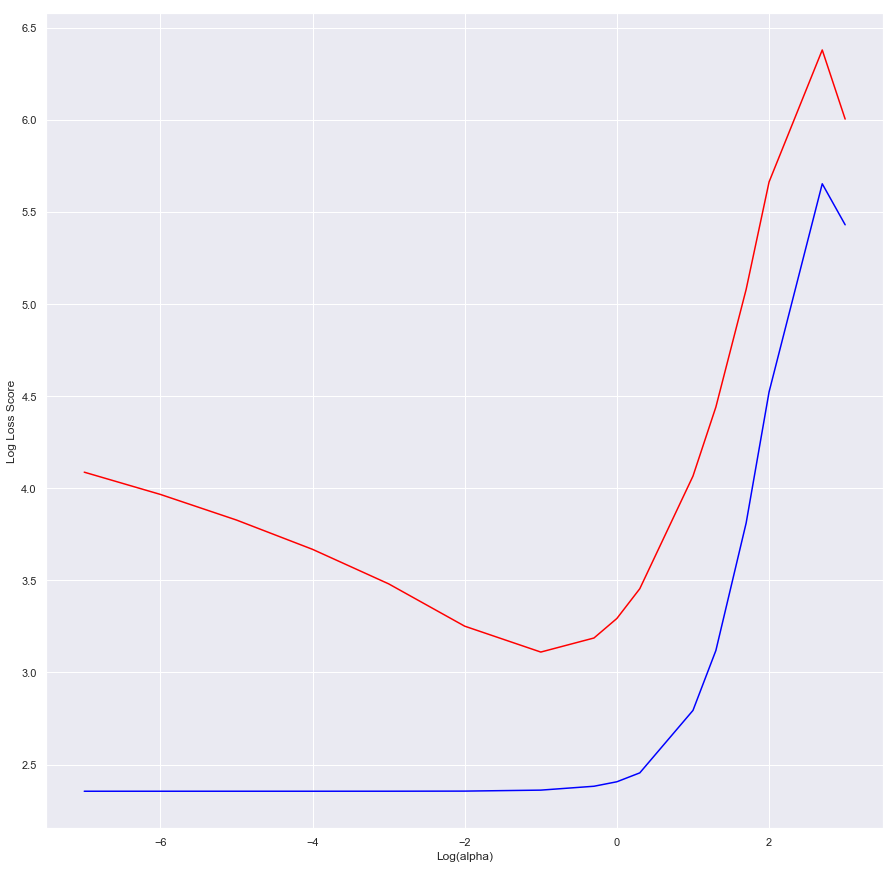

[2.3548073816485173, 2.354807494939585, 2.354808611286926, 2.354818644077839, 2.354894317647341, 2.3555025277077957, 2.3608282294748064, 2.3818727429799638, 2.4062515775266586, 2.4545554128220304, 2.7937571168393363, 3.119201238970482, 3.8119059172796232, 4.523520125480585, 5.654214706034914, 5.431457557023434]
[4.087778839727493, 3.9670012474695175, 3.8279209192823087, 3.6687022988345945, 3.481317531493901, 3.251305798918125, 3.110750655813337, 3.187130245524711, 3.29323346983246, 3.4547779928903064, 4.066348059194139, 4.4416351643262875, 5.080842564844885, 5.664117476750983, 6.380966379618436, 6.005629371660653]


In [245]:
# Train the MNB with reduced feature set

train_scores = []
dev_scores = []

# Assign data and label sets
train_data_mnb = mini_train_data_list[0][:,nonzero_idx_list_v1[best_feature_set_idx]]
train_labels_mnb=mini_train_labels_list[0]
dev_data_mnb=dev_data_list[0][:,nonzero_idx_list_v1[best_feature_set_idx]]
dev_labels_mnb = dev_labels_list[0]

alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]
for a in alphas:
    print('Running alpha of',a)
    mnb_v3 = MultinomialNB(alpha = a)
    train_predict = mnb_v3.fit(train_data_mnb, train_labels_mnb).predict_proba(train_data_mnb)
    train_score = metrics.log_loss(train_labels_mnb, train_predict)
    train_scores.append(train_score)
    dev_predict = mnb_v3.predict_proba(dev_data_mnb)
    dev_score = metrics.log_loss(dev_labels_mnb,dev_predict)
    dev_scores.append(dev_score)
    
# Plotting log loss scores
plt.plot(np.log10(alphas),train_scores, 'blue')
plt.plot(np.log10(alphas),dev_scores, 'red')
plt.xlabel('Log(alpha)')
plt.ylabel('Log Loss Score')
plt.show()

# Print outputs
print(train_scores)
print(dev_scores)

We actually see a better log loss score with an alpha of 1.0

In [246]:
best_alpha = alphas[np.argmin(dev_scores)]
print(best_alpha)

0.1


In [239]:
# For V3 data (after removing coefficients from L1 regularization)

mnb_final = MultinomialNB(alpha = best_alpha)
mnb_final.fit(train_data_mnb, train_labels_mnb)
pred_labels_final = mnb_final.predict(dev_data_mnb)
mnb_final_score = metrics.f1_score(dev_labels_mnb, pred_labels_final, average = 'micro')
mnb_final_log_loss = metrics.log_loss(dev_labels_mnb, mnb_final.predict_proba(dev_data_mnb))

print('The F1 score for a Multinomial Naive Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_final_score,4)))
print("Log loss for Multinomial Naive Bayes is {fm}".format(fm=mnb_final_log_loss))


The F1 score for a Multinomial Naive Bayes model (with feature engineering) is 0.2805
Log loss for Multinomial Naive Bayes is 3.110750655813337


### L2 Logistic Regression¶


In [248]:
# Assign data and label sets
train_data_l2 = mini_train_data_list[1][:,nonzero_idx_list_v1[best_feature_set_idx]]
train_labels_l2=mini_train_labels_list[1]
dev_data_l2=dev_data_list[1][:,nonzero_idx_list_v1[best_feature_set_idx]]
dev_labels_l2 = dev_labels_list[1]

lr_l2 = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123,solver = 'sag', max_iter=100, tol = 0.001)

cv_params = {'C': [0.01, 0.1, 1.0, 10.0]}

lr_l2_cv = GridSearchCV(estimator = lr_l2, param_grid = cv_params, cv = 3, scoring = 'neg_log_loss', n_jobs = -1, verbose = 10)
l2 = lr_l2_cv.fit(train_data_l2, train_labels_l2)
print('The best parameters for Logistic Regression (using L2 errors) are:', l2.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   23.7s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   23.8s remaining:   33.3s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   36.4s remaining:   26.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   38.7s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   42.4s finished


The best parameters for Logistic Regression (using L2 errors) are: {'C': 1.0}


Running c of 0.01
Running c of 0.1


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Running c of 1.0
Running c of 10.0


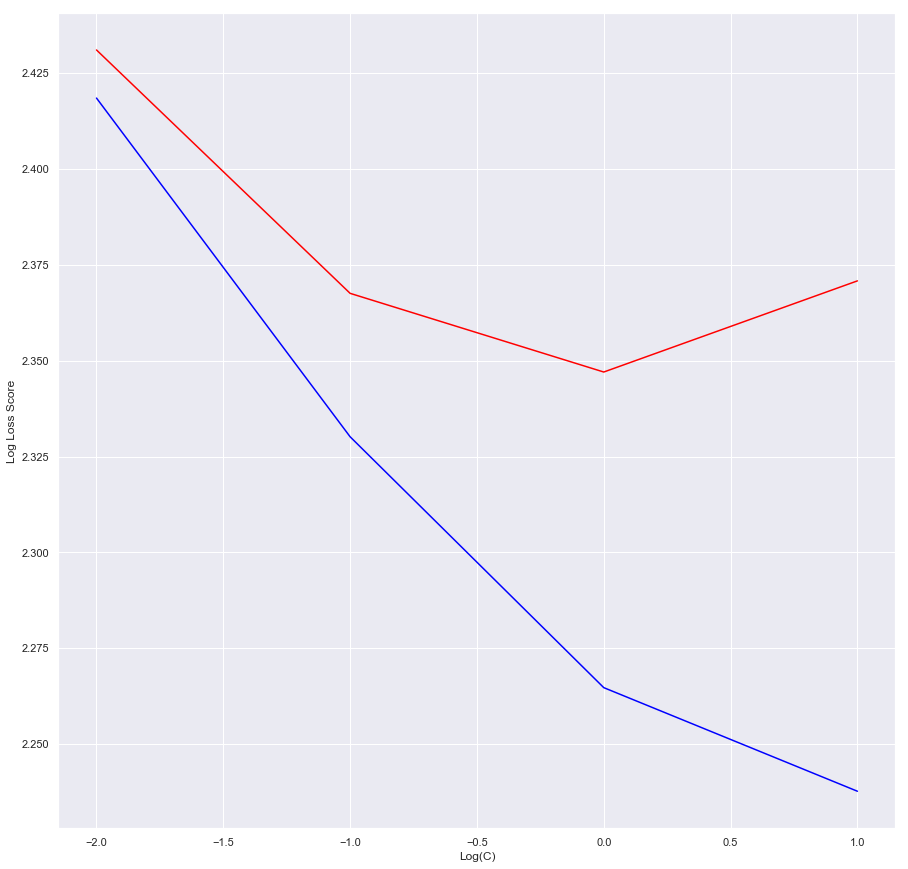

[2.4185077579929697, 2.3301488851635357, 2.264708468006204, 2.2376853994502017]
[2.431058659341026, 2.367567474873828, 2.3470447886213788, 2.37082200362224]


In [255]:
# For V2 data

train_scores = []
dev_scores = []

cs = [0.01, 0.1, 1.0, 10.0]
for c in cs:
    print('Running c of', c)
    l2 = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, solver = 'sag', C = c, max_iter=100, tol = 0.001)
    train_predict = l2.fit(train_data_l2, train_labels_l2).predict_proba(train_data_l2)
    train_score = metrics.log_loss(train_labels_l2, train_predict)
    train_scores.append(train_score)
    
    dev_predict = l2.predict_proba(dev_data_l2)
    dev_score = metrics.log_loss(dev_labels_l2,dev_predict,labels=np.unique(train_labels_l2))
    dev_scores.append(dev_score)

    
# Plotting log loss scores
plt.plot(np.log10(cs),train_scores, 'blue')
plt.plot(np.log10(cs),dev_scores, 'red')
plt.xlabel('Log(C)')
plt.ylabel('Log Loss Score')
plt.show()

# Print outputs
print(train_scores)
print(dev_scores)

In [258]:
best_c = cs[np.argmin(dev_scores)]
print('The best C is', best_c, 'when accounting for overfitting that can possibly happen on the dev set')

l2 = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = random_seed, solver = 'sag', C = best_c, max_iter=100, tol = 0.001)
pred_labels_l2 = l2.fit(train_data_l2, train_labels_l2).predict_proba(dev_data_l2)
l2_score = metrics.log_loss(dev_labels_l2, pred_labels_l2,labels=np.unique(train_labels_l2))
print('The Log Loss score for a Logistic Regression model (using L2 errors) is %s'% (l2_score))


The best C is 1.0 when accounting for overfitting that can possibly happen on the dev set
The Log Loss score for a Logistic Regression model (using L2 errors) is 2.3470447886213788


### Decision trees

In [262]:
# Assign data and label sets
train_data_dt = mini_train_data_list[2][:,nonzero_idx_list_v1[best_feature_set_idx]]
train_labels_dt=mini_train_labels_list[2]
dev_data_dt=dev_data_list[2][:,nonzero_idx_list_v1[best_feature_set_idx]]
dev_labels_dt = dev_labels_list[2]


parameters={'min_samples_split' : range(10,51,5),'max_depth': range(2,11,2)}
clf_tree=DecisionTreeClassifier()
clf=GridSearchCV(clf_tree,parameters,cv=3,n_jobs=-1,verbose=1,iid=True,scoring = 'neg_log_loss')
clf_optim  = clf.fit(train_data_dt,train_labels_dt)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: y_true and y_pred contain different number of classes 39, 38. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

In [ ]:
print(clf.cv_results_['params'][clf.best_index_])
print(clf_optim.best_score_ * -1)

In [ ]:
min_samples_split = range(10,51,5)
max_depth = [2,5,10,12,15]
dtc_train_scores = np.zeros((len(max_depth), len(min_samples_split)))
dtc_dev_scores = np.zeros((len(max_depth), len(min_samples_split)))

for idx_mss, mss in enumerate(min_samples_split):
    for idx_md, md in enumerate(max_depth):
        print('Training Model for min samples split of', mss, 'with a max depth of', md)
        dtc = DecisionTreeClassifier(max_depth = md, min_samples_split = mss)
        dtc.fit(train_data_v3,train_labels_v2)
        
        dtc_train_predict = dtc.predict_proba(train_data_v3)
        dtc_train_score = metrics.log_loss(train_labels_v2, dtc_train_predict)
        dtc_train_scores[idx_md, idx_mss] = dtc_train_score
        
        dtc_dev_predict = dtc.predict_proba(dev_data_v3)
        dtc_dev_score = metrics.log_loss(dev_labels_v2, dtc_dev_predict)
        dtc_dev_scores[idx_md, idx_mss] = dtc_dev_score
        
print(dtc_train_scores)
print(dtc_dev_scores)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = len(max_depth), sharex = False, sharey = False, figsize = (16, 5))

for md in range(len(max_depth)):
    ax = plt.subplot(1, len(max_depth), md + 1)
    ax.plot(min_samples_split, dtc_train_scores[md], 'b--')
    ax.plot(min_samples_split, dtc_dev_scores[md], 'r:')
    ax.set_title('Max Depth ' + str(max_depth[md]))
    ax.set_ylim(bottom = 0 , top = 3)



We see from the above that higher depths are leading to overfitting on the training data. The dev data log-loss score is increasing with higher depth. From the charts, it looks like a max depth of 5 is ideal, and the Min Sample Size doesn't matter. We will opt for the highest Min Sample Size as this means the model is more generalizable and is most parsimonious.

### Random Forest

In [ ]:
parameters={'n_estimators' : [10,15,20,50,100],
            'max_depth': range(2,10,2),
            'max_features': ['sqrt','log2', None],
            'min_samples_split' : range(100,500,50),
            'bootstrap': ['True','False']
           }
rfClf = RandomForestClassifier()
rfClf_search=GridSearchCV(rfClf,parameters,cv=3,n_jobs=-1,verbose=1)
rfClf_optim = rfClf_search.fit(train_data_v3,train_labels_v2)


In [ ]:
print(rfClf_optim.cv_results_['params'][rfClf_optim.best_index_])
print(rfClf_optim.best_score_)

In [ ]:
# Choose the best model and train for predictions on test data

rfClf = RandomForestClassifier(bootstrap=True,max_depth=8,max_features=None,min_samples_split=350,n_estimators=20,n_jobs=-1,verbose=1)
rfClf.fit(train_data_v2,train_labels_v2)

In [ ]:
# Iterating upon the above to find the best parameters for the reduced feature set
# Changing max depth

max_depth = [5,8,10,12]
rf_md_train_scores = np.zeros(len(max_depth))
rf_md_dev_scores = np.zeros(len(max_depth))

for idx_md, md in enumerate(max_depth):
    print('Training Model for a max depth of', md, 'keeping all other params constant')
    rf = RandomForestClassifier(bootstrap=True,max_depth = md,max_features=None,min_samples_split=350,n_estimators=20,n_jobs=-1,verbose=1)
    rf.fit(train_data_v3,train_labels_v2)
        
    rf_train_predict = rf.predict_proba(train_data_v3)
    rf_train_score = metrics.log_loss(train_labels_v2, rf_train_predict)
    rf_md_train_scores[idx_md] = rf_train_score
        
    rf_dev_predict = dtc.predict_proba(dev_data_v3)
    rf_dev_score = metrics.log_loss(dev_labels_v2, rf_dev_predict) + 
    rf_md_dev_scores[idx_md] = rf_dev_score
        
print(rf_md_train_scores)
print(rf_md_dev_scores)

In [ ]:
plt.plot(max_depth, rf_md_train_scores, 'b')
plt.plot(max_depth, rf_md_dev_scores, 'r')

best_max_depth = max_depth[np.argmin(rf_md_dev_scores)]

The best max depth doesn't affect the log-loss score of the dev dataset. Therefore we choose the most parsimonious (5)

In [ ]:
# Iterating upon the above to find the best parameters for the reduced feature set
# Changing max features

max_features = ['sqrt','log2', None]
rf_mf_train_scores = np.zeros(len(max_features))
rf_mf_dev_scores = np.zeros(len(max_features))

for idx_mf, mf in enumerate(max_features):
    print('Training Model for a max features of', mf, 'keeping all other params constant')
    rf = RandomForestClassifier(bootstrap=True,max_depth = best_max_depth,max_features = mf, min_samples_split=350,n_estimators=20,n_jobs=-1,verbose=1)
    rf.fit(train_data_v3,train_labels_v2)
        
    rf_train_predict = rf.predict_proba(train_data_v3)
    rf_train_score = metrics.log_loss(train_labels_v2, rf_train_predict)
    rf_mf_train_scores[idx_mf] = rf_train_score
        
    rf_dev_predict = dtc.predict_proba(dev_data_v3)
    rf_dev_score = metrics.log_loss(dev_labels_v2, rf_dev_predict) 
    rf_mf_dev_scores[idx_mf] = rf_dev_score 
        
print(rf_mf_train_scores)
print(rf_mf_dev_scores)


It turns out the dev dataset has the same f1 score regardless of the training method used. Therefore, we will use one of the less computationally intensive max features. Between log2 and sqrt, sqrt performed better. Thus we will set this as our best max features

In [ ]:
best_max_features = 'sqrt'

In [ ]:
# Iterating upon the above to find the best parameters for the reduced feature set
# Changing min samples split

min_samples_split = range(100,500,50)
rf_mss_train_scores = np.zeros(len(min_samples_split))
rf_mss_dev_scores = np.zeros(len(min_samples_split))

for idx_mss, mss in enumerate(min_samples_split):
    print('Training Model for a min samples split of', mss, 'keeping all other params constant')
    rf = RandomForestClassifier(bootstrap = True,max_depth = best_max_depth,max_features = best_max_features, min_samples_split = mss,n_estimators=20,n_jobs=-1,verbose=1)
    rf.fit(train_data_v3,train_labels_v2)
        
    rf_train_predict = rf.predict_proba(train_data_v3)
    rf_train_score = metrics.log_loss(train_labels_v2, rf_train_predict)
    rf_mss_train_scores[idx_mss] = rf_train_score
        
    rf_dev_predict = dtc.predict_proba(dev_data_v3)
    rf_dev_score = metrics.log_loss(dev_labels_v2, rf_dev_predict)
    rf_mss_dev_scores[idx_mss] = rf_dev_score
        
print(rf_mss_train_scores)
print(rf_mss_dev_scores)

In [ ]:
plt.plot(min_samples_split, rf_mss_train_scores, 'b')
plt.plot(min_samples_split, rf_mss_dev_scores, 'r')

best_min_samples_split = min_samples_split[np.argmin(rf_mss_dev_scores)]
print('The Best min samples split is',best_min_samples_split)

Again going with the most parsimonious option as all values return the same log loss score on the dev dataset.

In [ ]:
best_min_samples_split = 450

In [ ]:
# Iterating upon the above to find the best parameters for the reduced feature set
# Changing n estimators

n_estimators = [10,15,20,50,100]
rf_ne_train_scores = np.zeros(len(n_estimators))
rf_ne_dev_scores = np.zeros(len(n_estimators))

for idx_ne, ne in enumerate(n_estimators):
    print('Training Model for n estimators of', ne, 'keeping all other params constant')
    rf = RandomForestClassifier(bootstrap = True,max_depth = best_max_depth,max_features = best_max_features, min_samples_split = best_min_samples_split,n_estimators = ne,n_jobs=-1,verbose=1)
    rf.fit(train_data_v3,train_labels_v2)
        
    rf_train_predict = rf.predict_proba(train_data_v3)
    rf_train_score = metrics.log_loss(train_labels_v2, rf_train_predict)
    rf_ne_train_scores[idx_ne] = rf_train_score
        
    rf_dev_predict = dtc.predict_proba(dev_data_v3)
    rf_dev_score = metrics.log_loss(dev_labels_v2, rf_dev_predict)
    rf_ne_dev_scores[idx_ne] = rf_dev_score
        
print(rf_ne_train_scores)
print(rf_ne_dev_scores)

In [ ]:
plt.plot(n_estimators, rf_ne_train_scores, 'b')
plt.plot(n_estimators, rf_ne_dev_scores, 'r')

Hyperparameter tuning didn't alter our dev log-loss score at all. Also, this score is not as good as our other models. Thus, we will not move forward with random forest as our classifier of choice

## AdaBoosted Decision Trees

We investigated adaboosting as these have been known to perform well for samples with skewed classes

In [ ]:
dt_stump=DecisionTreeClassifier(max_depth=8, min_samples_split=20)
dt_stump.fit(train_data_v3, train_labels_v2)

In [ ]:
# Testing the Adaboost method with various n estimators and learning rates. 
# We find the log-loss score of both the training and the dev dataset to ensure we aren't overfitting on the training dataset

n_estimators = [20, 50, 100, 200, 400]
learning_rate = [0.1, 0.5, 0.9]
ada_train_scores = np.zeros((len(learning_rate), len(n_estimators)))
ada_dev_scores = np.zeros((len(learning_rate), len(n_estimators)))
                 
for idx_n, n in enumerate(n_estimators):
    for idx_lr, lr in enumerate(learning_rate):
        print('Training Model for n_estimators of', n, 'with a learning rate of', lr)
        ada_real = AdaBoostClassifier(
            base_estimator=dt_stump,
            learning_rate = lr,
            n_estimators = n,
            algorithm="SAMME.R")
        ada_train_predict = ada_real.fit(train_data_v3, train_labels_v2).predict_proba(train_data_v3)
        ada_train_score = metrics.log_loss(train_labels_v2, ada_train_predict)
        ada_train_scores[idx_lr, idx_n] = ada_train_score
        
        ada_dev_predict = ada_real.predict_proba(dev_data_v3)
        ada_dev_score = metrics.log_loss(dev_labels_v2, ada_dev_predict)
        ada_dev_scores[idx_lr, idx_n] = ada_dev_score
        
print(ada_train_scores)
print(ada_dev_scores)


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False)

for i in range(len(learning_rate)):
    ax = plt.subplot(1, 3, i+1)
    ax.plot(n_estimators, ada_train_scores[i], 'blue')
    ax.plot(n_estimators, ada_dev_scores[i], 'red')
    ax.set_title('Learning Rate ' + str(learning_rate[i]))



We see the best log-loss scores are coming from models where the learning rate is small (0.1) and n_estimators is a small value (20). From the plots above, we demonstrated that we are not overfitting the model on the traiing dataset here, as the log-loss curves of the dev dataset closely mirror the training dataset.

In [ ]:
# Now setting the model for the optimized set of parameters found above

ada_real_optimized = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate = 0.1,
    n_estimators = 20,
    algorithm="SAMME.R")

ada_real_optimized.fit(train_data_v3, train_labels_v2)
ada_train_optimized_predict = ada_real_optimized.predict_proba(dev_data_v3)

## Neural network

In [ ]:
import tensorflow as tf
from tensorflow import keras

config = tf.ConfigProto()
config.intra_op_parallelism_threads = 0
config.inter_op_parallelism_threads = 0

In [ ]:
print(len(data_classes_v2))
print(train_data_v2.shape)

In [ ]:
modelNN = keras.Sequential([
    keras.layers.Flatten(input_shape=(train_data_v2.shape[1],)),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(len(data_classes_v2), activation=tf.nn.softmax)
])

In [ ]:
modelNN.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelNN.fit(train_data_v2,train_labels_v2, epochs=5,batch_size=1000)


In [ ]:
val_loss, val_acc = modelNN.evaluate(dev_data_v2,dev_labels_v2)

print('Test accuracy:', val_acc)

## Model Choice

#### We chose the random forest classifier as the model for making final predictions on test data

More details on model choice will be included in the final report

### Summary of hyperparameter optimized models


In [ ]:
# Best MNB Model

mnb_final = MultinomialNB(alpha = 1.0)
mnb_final.fit(train_data_v3, train_labels_v2)
mnb_pred_labels_final = mnb_final.predict(dev_data_v3)
mnb_final_score = metrics.f1_score(dev_labels_v2, mnb_pred_labels_final, average = 'micro')
mnb_probs = mnb_final.predict_proba(dev_data_v3)
mnb_probs_train = mnb_final.predict_proba(train_data_v3)
mnb_final_log_loss = metrics.log_loss(dev_labels_v2, mnb_probs)

print('The F1 score for a Multinomial Naive Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_final_score,4)))
print("Log loss for Multinomial Naive Bayes is {fm}".format(fm=mnb_final_log_loss))


In [ ]:
# Best L2 Model

best_c = 1.0
l2_final = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, solver = 'sag', C = best_c, max_iter=100, tol = 0.001)
l2_final.fit(train_data_v3, train_labels_v2)
l2_pred_labels_final = l2_final.predict(dev_data_v3)
l2_final_score = metrics.f1_score(dev_labels_v2, l2_pred_labels_final, average = 'micro')
l2_probs_train = l2_final.predict_proba(train_data_v3)
l2_probs = l2_final.predict_proba(dev_data_v3)
l2_final_log_loss = metrics.log_loss(dev_labels_v2, l2_probs)

print('The F1 score for a L2 model (with feature engineering) is {fm}'.format(fm=round(l2_final_score,4)))
print("Log loss for L2 is {fm}".format(fm=l2_final_log_loss))

In [ ]:
# Best Decision Tree Model

best_max_depth = 5.0
best_min_sample_split = 50
dtc_final = DecisionTreeClassifier(max_depth = best_max_depth, min_samples_split = best_min_sample_split)
dtc_final.fit(train_data_v3, train_labels_v2)
dtc_pred_labels_final = dtc_final.predict(dev_data_v3)
dtc_final_score = metrics.f1_score(dev_labels_v2, dtc_pred_labels_final, average = 'micro')
dtc_probs_train = dtc_final.predict_proba(train_data_v3)
dtc_probs = dtc_final.predict_proba(dev_data_v3)
dtc_final_log_loss = metrics.log_loss(dev_labels_v2, dtc_probs)

print('The F1 score for a Decision Tree model (with feature engineering) is {fm}'.format(fm=round(dtc_final_score,4)))
print("Log loss for Decision Tree is {fm}".format(fm=dtc_final_log_loss))

In [ ]:
# Best Random Forest Model

best_min_samples_split = 450
best_max_features = 'sqrt'
best_max_depth = 5
best_n_estimators = 10

rf_final = RandomForestClassifier(bootstrap = True,max_depth = best_max_depth,max_features = best_max_features, min_samples_split = best_min_samples_split,n_estimators = best_n_estimators,n_jobs=-1,verbose=1)
rf_final.fit(train_data_v3, train_labels_v2)
rf_pred_labels_final = rf_final.predict(dev_data_v3)
rf_final_score = metrics.f1_score(dev_labels_v2, rf_pred_labels_final, average = 'micro')
rf_probs_train = rf_final.predict_proba(train_data_v3)
rf_probs = rf_final.predict_proba(dev_data_v3)
rf_final_log_loss = metrics.log_loss(dev_labels_v2, rf_probs)

print('The F1 score for a Random Forest model (with feature engineering) is {fm}'.format(fm=round(rf_final_score,4)))
print("Log loss for Random Forest is {fm}".format(fm=rf_final_log_loss))

In [ ]:
# Best Adaboost Model


ada_final = AdaBoostClassifier(base_estimator=dt_stump,learning_rate = 0.1,n_estimators = 20,algorithm="SAMME.R")
ada_final.fit(train_data_v3, train_labels_v2)
ada_pred_labels_final = ada_final.predict(dev_data_v3)
ada_final_score = metrics.f1_score(dev_labels_v2, ada_pred_labels_final, average = 'micro')
ada_probs_train = ada_final.predict_proba(train_data_v3)
ada_probs = ada_final.predict_proba(dev_data_v3)
ada_final_log_loss = metrics.log_loss(dev_labels_v2, ada_probs)

print('The F1 score for a Adaboost model (with feature engineering) is {fm}'.format(fm=round(ada_final_score,4)))
print("Log loss for Adaboost is {fm}".format(fm=ada_final_log_loss))


In [ ]:
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('Model Type','Log-Loss','F1','Hyperparam 1','Hyperparam 2','Hyperparam 3','Hyperparam 4'))
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('Multinomial NB',round(mnb_final_log_loss,5),round(mnb_final_score,5),'Alpha 1.0','','',''))
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('L2 Regression',round(l2_final_log_loss,5),round(l2_final_score,5),'C 1.0','','',''))
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('Decision Trees',round(dtc_final_log_loss,5),round(dtc_final_score,5),'Max Depth 5','Min Sample Split 50','',''))
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('Random Forest',round(rf_final_log_loss,5),round(rf_final_score,5),'Max Depth 5','Min Sample Split 450','Max Features SQRT','n_est 10'))
print("{:<15} {:<10} {:<10} {:<20} {:<20} {:<20} {:<20}".format('Adaboost',round(ada_final_log_loss,5),round(ada_final_score,5),'Learning Rate 0.1','N_est 20','',''))

### Combining the best 3 models (by Log Loss Score)

Our best 3 modesl are Multinomial NB, Decision Trees, and L2 Regression. Let's try averaging their probabilities and taking the L2 score

In [ ]:
avg_probs = (mnb_probs + l2_probs + dtc_probs) / 3
avg_final_log_loss = metrics.log_loss(dev_labels_v2, avg_probs)
print('Taking the log loss score of the average probabilites of all 3 models:', avg_final_log_loss)

The Log Loss Score is pretty good, but L2 by itself is still better. Let's try taking a L2 Logistic Regression of the three probability arrays as another method of combining the results

In [ ]:
train_combine = np.concatenate((mnb_probs_train, l2_probs_train ,dtc_probs_train), axis = 1)
dev_combine = np.concatenate((mnb_probs, l2_probs ,dtc_probs), axis = 1)

print(train_combine.shape)
print(dev_combine.shape)

In [ ]:
# For V2 data

train_scores = []
dev_scores = []

cs = [0.01, 0.1, 1.0, 10.0, 100]
for c in cs:
    print('Running c of', c)
    l2_combine = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, solver = 'sag', C = c, max_iter=100, tol = 0.001)
    train_predict = l2_combine.fit(train_combine, train_labels_v2).predict_proba(train_combine)
    train_score = metrics.log_loss(train_labels_v2, train_predict)
    train_scores.append(train_score)
    
    dev_predict = l2_combine.predict_proba(dev_combine)
    dev_score = metrics.log_loss(dev_labels_v2,dev_predict)
    dev_scores.append(dev_score)

# Print outputs
print(train_scores)
print(dev_scores)

# Plotting log loss scores
plt.plot(np.log10(cs),train_scores, 'blue')
plt.plot(np.log10(cs),dev_scores, 'red')
plt.xlabel('Log(C)')
plt.ylabel('Log Loss Score')
plt.show()

print('The best log loss score we see with this combined method:', np.min(dev_scores))

This model still did fairly well. L2 still is marginally better but we can try uploading this to Kaggle too!

## Predictions on test data

*Note:* Test predictions should be an array of probabilities or an array of predicted labels stored in a variable test_pred. Use the proper submission file generator below

In [ ]:
# Predict on test data

'''predictions using random forest model'''
#preds = rfClf.predict(test_data_encoded_v2)

## Predictions using neural network model
pred_probs = modelNN.predict(test_data_encoded_v2)
preds = np.argmax(pred_probs,axis=1)

data_classes=data_classes_v2


In [ ]:
print(pred_probs[:5])

In [ ]:
# Running on MNB model with test data for now, will switch to random forest later
test_pred = mnb_v2_optimized.predict_proba(test_data_encoded_v2)
print(test_pred.shape)

### Generating CSV file for submission to Kaggle - Baseline Submission
Our original baseline submission was a KNN model where n = 1. However, we felt it made more sense to make the baseline submission a dataframe which predicts the most common crime for each sample in the test dataset. This will be our model to beat

In [ ]:
# Making a baseline submission that just takes the most frequent-occurring crime, and predicting all crimes in the test data frame are of that label

submission_no_ml = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)
submission_no_ml['Id'] = sample_submission['Id']
submission_no_ml['LARCENY/THEFT'] = 1
submission_no_ml.to_csv('baseline_submission_2.csv', index = False)

### Generating CSV file for submission to Kaggle - Use this if using predicted labels

In [ ]:
## Print formatted output for submission CSV

# Looking at format of output
#print(sample_submission.head())
print('sample submission shape', sample_submission.shape)

# Now put results in a dataframe 
all_ids = test["Id"].values

# From encoded categories, get normal labels
#labeled_preds = [data_classes[i] for i in preds]
labeled_preds = pred_probs

# Make dateframe
d = {'Id': all_ids, 'Label': labeled_preds}

# Make the results dummy columns
df = pd.DataFrame(data = d)
results = pd.get_dummies(df, prefix=[''],prefix_sep = '')

# To ensure we have all columns, copy data into the schema of sample_submission
submission = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)

col_names = list(results.columns.values)
for col in col_names:
    submission[col] = results[col]

    
print('final shape',submission.shape )
## Save the predictions to submission CSV file
submission.to_csv('submission.csv', index = False)

#print(submission)

### Generating CSV file for submission to Kaggle - Use this for predicted probabilities

In [ ]:
print(test_pred[:,0])

# To ensure we have all columns, copy data into the schema of sample_submission
submission = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)

col_names = list(submission.columns.values)
for i, col in enumerate(col_names):
    if col == 'Id':
        submission[col] = sample_submission[col]
    else:
        submission[col] = test_pred[:,i-1]

In [ ]:
print(submission.shape)

# Comment this out when you are ready to create the CSV object
# submission.to_csv('submission_probs.csv', index = False)